In [3]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline
from scipy.stats import norm 
import keras.backend as Kb
import tensorflow as tf
from keras.layers import Dense, Input, Activation, Multiply
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.layers import Layer
from keras.initializers import VarianceScaling
from keras.regularizers import l2 as regularizers_l2
from tensorflow.python import keras
from sklearn.metrics import mean_absolute_error as mae
import time
import gc

import warnings
warnings.filterwarnings('ignore')

from platform import python_version

print(python_version())
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

3.8.5
TensorFlow version: 2.8.0
Keras version: 2.6.0


### Building differential neural network

In [14]:
gc.collect()
Kb.clear_session()

class DiffLayer(Layer):

    def __init__(self, inputLayer, outputDim, **kwargs):
      self.outputDim = outputDim
      self.inputLayer = inputLayer
      super(DiffLayer, self).__init__(**kwargs)

    def build(self, inputShape):
      # Create a trainable weight variable for this layer.
      self.kernel = Kb.transpose(self.inputLayer.kernel)
      super(DiffLayer, self).build(inputShape)  # Be sure to call this somewhere!

    def call(self, x):
      return Kb.dot(x, self.kernel)

    def computeOutputShape(self, inputShape):
      return (inputShape[0], self.outputDim)

def createNeuralNetwork(nLayers,units,inputDim):
  reg_strength = 0.000 

  #Input layer
  inputs = Input(shape=(inputDim,))

  #First hidden layer
  layer1 = Dense(units, kernel_initializer=VarianceScaling(), kernel_regularizer=regularizers_l2(l=reg_strength)) #when activation is not specified, the identity is used
  #https://androidkt.com/kernel-bias-and-activity-layer-weight-regularizers-keras/
  z1 = layer1(inputs) #as a^0=x
  hiddenLayers = [layer1]
  hiddenZ = [z1]

  if nLayers > 1:
    for n in range(nLayers-1):
      tempA = Activation("softplus")(hiddenZ[-1])
      tempLayer = Dense(units, kernel_initializer=VarianceScaling(), kernel_regularizer=regularizers_l2(l=reg_strength))
      tempZ = tempLayer(tempA)
      hiddenLayers.append(tempLayer)
      hiddenZ.append(tempZ)

  #Output layer (price layer)
  outputA = Activation("softplus")(hiddenZ[-1])
  priceLayer = Dense(1, name = 'Price_output', kernel_initializer=VarianceScaling(), kernel_regularizer = regularizers_l2(l=reg_strength))
  price = priceLayer(outputA)

  #First differential layer
  diffTerm = Activation("sigmoid")(hiddenZ[-1]) #As sigmoid is the derivative of Softplus
  firstTerm = Kb.transpose(priceLayer.kernel) #As y_bar=1 and not equal to price, before Kb.dot(price,Kb.transpose(price_layer.kernel))
  dif1 = Multiply()([diffTerm,firstTerm])
  difLayers = [dif1]

  if nLayers > 1:
    for i in range(nLayers-1):
      tempDiffTerm = Activation("sigmoid")(hiddenZ[-i-2])
      tempFirstTerm = DiffLayer(hiddenLayers[-i-1],units)(difLayers[-1]) 
      tempDif = Multiply()([tempDiffTerm,tempFirstTerm])
      difLayers.append(tempDif)

  delta = DiffLayer(hiddenLayers[0],1)(difLayers[-1])

  model = Model(inputs=[inputs], outputs=[price, delta])
  
  return model


### Building differential polynomial regression

In [15]:
def DifferentialRegression(d,x,y,z,x_test,w):
    polynomial_features = PolynomialFeatures(degree=d, include_bias=True)
    phi = polynomial_features.fit_transform(x)
    powers = polynomial_features.powers_
    deltaphi = phi[:,:,np.newaxis] * powers / (x[:,np.newaxis,:] + epsilon) #NaN arise if epsilon is omitted
    phiTphi = np.tensordot(deltaphi,deltaphi,axes=([0,2],[0,2]))
    phiTz = np.tensordot(deltaphi,z,axes=([0,2],[0,1])).reshape(-1,1)
    det = round(np.linalg.det(w * np.dot(phi.T,phi) + (1-w) * phiTphi),50)
    if det == 0:
        result = print("Matrix is singular with determinant", det, "rounded to nearest 25 decimals")
    else:
        firstTerm = np.linalg.pinv((w * np.dot(phi.T,phi) + (1-w) * phiTphi))
        secondTerm = w * np.dot(phi.T,y) + (1-w) * phiTz
        beta = np.dot(firstTerm,secondTerm).reshape(-1, 1)
        phi_test = polynomial_features.transform(x_test)
        deltaphi_test = phi_test[:,:,np.newaxis] * powers / (x_test[:,np.newaxis,:] + epsilon)
        y_hat = np.dot(phi_test,beta)
        z_hat = np.tensordot(deltaphi_test,beta,axes=([1,0])).reshape(deltaphi_test.shape[0],-1)
        result = beta, y_hat.reshape(-1, 1), z_hat.reshape(-1, 1)
    return result


### Differential PCA

In [16]:
def DiffPCA(X, Z, tolerance):
    m, n = X.shape
    covMatrix = np.dot(Z.T,Z)/m
        
    D, P = np.linalg.eigh(covMatrix) #D eigenvalues in ascending order, and P are the eigenvector

    D = D[::-1]
    P = P[:,::-1]
      
    sumD = np.cumsum(D)
    totalVariance = sumD[-1]

    sumD /= totalVariance
    tolerance = np.searchsorted(sumD, tolerance) + 1

    DTilde = D[:tolerance]
    PTilde = P[:,:tolerance]

    return PTilde


def encoder(X, Z, PT):
    L = np.dot(X,PT)
    S = np.dot(Z,PT)
    
    return L, S

### Generating weights, correlations and volatilities of the stocks in the underlying basket

In [35]:
def GenerateBasketWeights(n):
    w = np.random.uniform(size=n)
    return w/np.sum(w)

def GenerateCorrMatrix(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = np.dot(randoms.T,randoms)
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])

def GenerateVolatilities(n,lower,upper):
    vols = np.random.uniform(low=lower, high=upper, size=n)
    return vols

def NormalizationMultiDim(X,Y,Z):
    N = np.column_stack((Y,Z))   # training works best in normalized space, so we normalized our inputs and labels 
    meanX = np.mean(X,axis = 0)
    stdX = np.std(X,axis = 0)
    meanDeriv = np.repeat(0, nAssets,axis=0).reshape(1,-nAssets)
    meanPayoff = np.array([np.mean(Y)])
    meanY = np.column_stack((meanPayoff,meanDeriv))
    multTerm = np.array([1/stdX])
    stdY = np.std(Y) * np.column_stack((1,multTerm))

    normX = (X - meanX) / stdX
    normY = (N - meanY) / stdY
    
    return normX, meanX, stdX, normY, meanY, stdY

### Market models in multiple dimensions

In [36]:
#Bachelier
def GenerateDataBachelierBasketNN(nSim, K, sigma, spot, T, seed, nAssets, weights, correlation): #T is time to maturity
    vT = np.diag(sigma)
    cov = np.linalg.multi_dot([vT, correlation, vT])
    chol = np.linalg.cholesky(cov)
    
    np.random.seed(seed)
    
    T0 = 1
    
    s0 = K + np.sqrt(T0) * np.dot(np.random.normal(size=(nSim,nAssets)),chol.T)
    b0 = np.dot(s0,weights)
    wT = np.random.normal(size=(nSim,nAssets))
    sT = s0 + np.sqrt(T) * np.dot(wT,chol.T)
    bT = np.dot(sT,weights)
    
    payoff = np.maximum(0, bT - K)
    deriv = np.where(bT > K, 1, 0).reshape(-1, 1) * weights.reshape(1, -1)
    
    return s0.reshape(-1,nAssets), b0, payoff, deriv.reshape(-1, nAssets), cov

def BachelierBasketNN(S, K, cov, T, weights, nAssets, greek):
    A = np.dot(S,weights)
    basketSigma = np.sqrt(np.linalg.multi_dot([w.T, cov, w]))
    d = (A - K) / basketSigma / np.sqrt(T)
    
    if greek == 0:
        val = basketSigma * np.sqrt(T) * norm.pdf(d) + (A - K) * norm.cdf(d)
        return val
    elif greek == 1: 
        delta = norm.cdf(d)
        return delta
    else:
        return 0

### Basket Call Option for Bachelier in Neural network withput delta-regularization

In [37]:
T = 1
nAssets=10
K = 1
w = GenerateBasketWeights(nAssets)
corr = GenerateCorrMatrix(nAssets)
vol = GenerateVolatilities(nAssets,0.1,0.4)
xTest, bTest, yTest, zTest, covTest = GenerateDataBachelierBasketNN(2000, 1, vol, 1, 1, 898, nAssets, w, corr)

X, B, Y, Z, cov = GenerateDataBachelierBasketNN(30000, 1, vol, 1, 1, 2022, nAssets, w, corr)
normX, meanX, stdX, normY, meanY, stdY = NormalizationMultiDim(X,Y,Z)

Text(0, 0.5, 'Basket call delta')

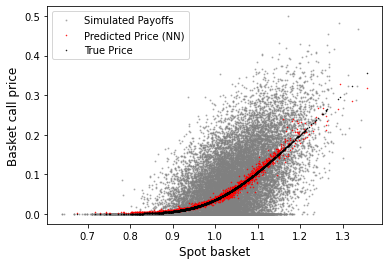

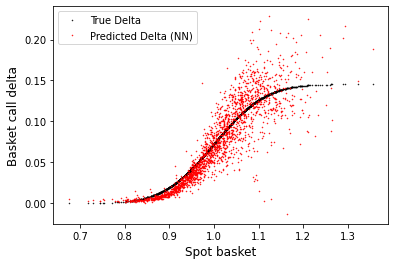

In [39]:
t0=time.time()
tf.keras.backend.clear_session()
modelMultiDim = createNeuralNetwork(4,20,nAssets)
modelMultiDim.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', loss_weights = [1,0])
history = modelMultiDim.fit(normX,[normY[:,0],normY[:,1:(nAssets+1)]], epochs = 100, batch_size = 1024, verbose = 0)
t1 = time.time()
#print('Training time: ',t1-t0)

#truePrices = BachelierBasketNN(xAxisMultiDim,K,cov,T,w,nAssets,greek=0)
#predPrices = (model_MultiDim.predict((xAxisMultiDim - meanX) / stdX)[0] * stdY[0,0] + meanY[0,0])
truePrices = BachelierBasketNN(xTest,K,cov,T,w,nAssets,greek=0)
predPrices = (modelMultiDim.predict((xTest - meanX) / stdX)[0] * stdY[0,0] + meanY[0,0])

fig, ax = plt.subplots()
#ax.set_ylim(-0.01,0.7)
#ax.set_ylim(-0.01,0.6) #ax.set_ylim(-0.1,0.80)
ax.plot(B,Y,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
ax.plot(bTest, predPrices, 'o', label = 'Predicted Price (NN)', markersize = 0.5,color = "red")
ax.plot(bTest, truePrices, 'o',label = 'True Price',markersize = 0.5, color="black")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call price',fontsize = 12)
#plt.show(fig)

trueDelta = BachelierBasketNN(xTest,K,cov,T,w,nAssets,greek=1)
nyTrueDelta = np.dot(trueDelta.reshape(-1,1),w.reshape(1,-1))
predDelta = (modelMultiDim.predict((xTest - meanX) / stdX)[1] * stdY[0,0] / stdX[0]).reshape(-1,nAssets)

fig, ax = plt.subplots()
#ax.set_xlim(0.20,1.80)
#ax.set_ylim(-0.01,0.13)
ax.plot(bTest, nyTrueDelta[:,0], 'o',label = 'True Delta',markersize = 0.5, color="black")
ax.plot(bTest, predDelta[:,0], 'o', label = 'Predicted Delta (NN)', markersize = 0.5,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call delta',fontsize = 12)
#plt.show(fig)

Training time:  13.08866810798645


Text(0, 0.5, 'Basket call delta')

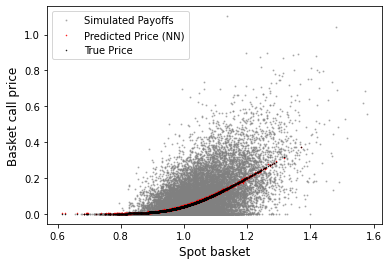

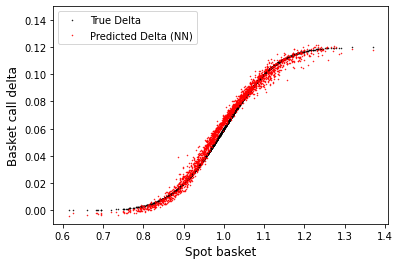

In [45]:
xTest, bTest, yTest, zTest, covTest = GenerateDataBachelierBasketNN(2000, 1, vol, 1, 1, 2804, nAssets, w, corr)

t0=time.time()
modelMultiDimDiff = createNeuralNetwork(4,20,nAssets)
modelMultiDimDiff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', loss_weights = [0.5,0.5])
history = modelMultiDimDiff.fit(normX,[normY[:,0],normY[:,1:(nAssets+1)]], epochs = 100, batch_size = 1024, verbose = 0)
t1 = time.time()
print('Training time: ',t1-t0)

#truePrices = BachelierBasketNN(xAxisMultiDim,K,cov,T,w,nAssets,greek=0)
#predPrices = (model_MultiDim.predict((xAxisMultiDim - meanX) / stdX)[0] * stdY[0,0] + meanY[0,0])
truePrices = BachelierBasketNN(xTest,K,cov,T,w,nAssets,greek=0)
predPrices = (modelMultiDimDiff.predict((xTest - meanX) / stdX)[0] * stdY[0,0] + meanY[0,0])

fig, ax = plt.subplots()
#ax.set_ylim(-0.01,0.7)
#ax.set_ylim(-0.01,0.6) #ax.set_ylim(-0.1,0.80)
ax.plot(B,Y,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
ax.plot(bTest, predPrices, 'o', label = 'Predicted Price (NN)', markersize = 0.5,color = "red")
ax.plot(bTest, truePrices, 'o',label = 'True Price',markersize = 0.5, color="black")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call price',fontsize = 12)
#plt.show(fig)

trueDelta = BachelierBasketNN(xTest,K,cov,T,w,nAssets,greek=1)
trueDelta = np.dot(trueDelta.reshape(-1,1),w.reshape(1,-1))
predDelta = (modelMultiDimDiff.predict((xTest - meanX) / stdX)[1] * stdY[0,0] / stdX[0]).reshape(-1,nAssets)
    
fig, ax = plt.subplots()
#ax.set_xlim(0.20,1.80)
ax.set_ylim(-0.01,0.15)
ax.plot(bTest, trueDelta[:,0], 'o',label = 'True Delta',markersize = 0.5, color="black")
ax.plot(bTest, predDelta[:,0], 'o', label = 'Predicted Delta (NN)', markersize = 0.5,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call delta',fontsize = 12)
#plt.show(fig)

### PCA in Practice

Text(0, 0.5, 'Basket call delta')

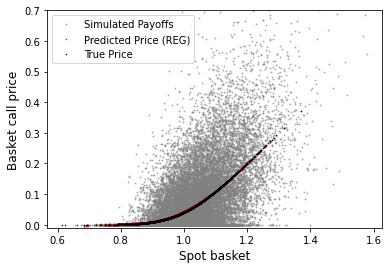

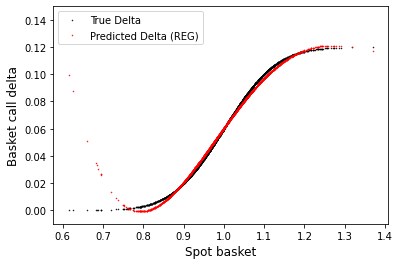

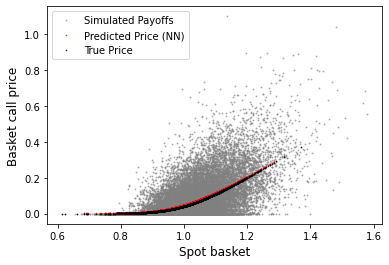

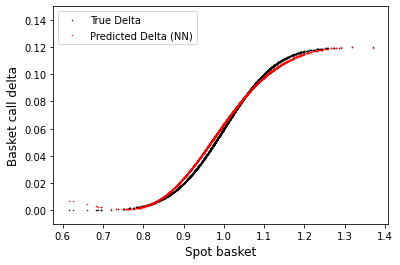

In [46]:
toleranceError=0.001
epsilon = 1.0e-08

t0=time.time()
pTilde = DiffPCA(X,Z,toleranceError)
L, S = encoder(X,Z,pTilde)
t1 = time.time()
#print("train time:",t1-t0)
Ltest, Stest = encoder(xTest,zTest,pTilde)

t2 = time.time()
predPrices = DifferentialRegression(7, L, Y.reshape(-1,1), S, Ltest, 0.5)[1]
t3 = time.time()
#print("train time:",t3-t2)
predDeltas = DifferentialRegression(7, L, Y.reshape(-1,1), S, Ltest, 0.5)[2]
predDeltas = np.dot(predDeltas,pTilde.T)

fig, ax = plt.subplots()
ax.plot(B,Y,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)  
ax.plot(bTest.reshape(-1,1), predPrices.reshape(-1,1), 'o', label = 'Predicted Price (REG)', markersize=0.5,color = "red") 
ax.plot(bTest.reshape(-1,1), truePrices.reshape(-1,1), 'o',label = 'True Price',markersize=0.5, color="black")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call price',fontsize = 12)
ax.set_ylim(-0.01,0.7)
#plt.show(fig)

fig, ax = plt.subplots()
ax.plot(bTest.reshape(-1,1), trueDelta[:,0].reshape(-1,1), 'o',label = 'True Delta',markersize=0.5, color="black") 
ax.plot(bTest.reshape(-1,1), predDeltas[:,0].reshape(-1,1), 'o', label = 'Predicted Delta (REG)', markersize=0.5,color = "red") 
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call delta',fontsize = 12)
#ax.set_xlim(-0.01,0.15)
ax.set_ylim(-0.01,0.15)
#plt.show(fig)


t0=time.time()
modelMultiDimDiffPCA = createNeuralNetwork(4,20,1)
modelMultiDimDiffPCA.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', loss_weights = [0.5,0.5])
history = modelMultiDimDiffPCA.fit(L,[Y,S], epochs = 100, batch_size = 1024, verbose = 0)
t1 = time.time()
#print('Training time: ',t1-t0)

#truePrices = BachelierBasketNN(xAxisMultiDim,K,cov,T,w,nAssets,greek=0)
#predPrices = (model_MultiDim.predict((xAxisMultiDim - meanX) / stdX)[0] * stdY[0,0] + meanY[0,0])
truePrices = BachelierBasketNN(xTest,K,cov,T,w,nAssets,greek=0)
predPrices = (modelMultiDimDiffPCA.predict(Ltest)[0])

fig, ax = plt.subplots()
#ax.set_ylim(-0.01,0.7)
#ax.set_ylim(-0.01,0.6) #ax.set_ylim(-0.1,0.80)
ax.plot(B,Y,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
ax.plot(bTest, predPrices, 'o', label = 'Predicted Price (NN)', markersize = 0.5,color = "red")
ax.plot(bTest, truePrices, 'o',label = 'True Price',markersize = 0.5, color="black")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call price',fontsize = 12)
#plt.show(fig)

trueDelta = BachelierBasketNN(xTest,K,cov,T,w,nAssets,greek=1)
trueDelta = np.dot(trueDelta.reshape(-1,1),w.reshape(1,-1))
predDelta = np.dot(modelMultiDimDiffPCA.predict(Ltest)[1],pTilde.T)
    
fig, ax = plt.subplots()
#ax.set_xlim(0.20,1.80)
ax.set_ylim(-0.01,0.15)
ax.plot(bTest, trueDelta[:,0], 'o',label = 'True Delta',markersize = 0.5, color="black")
ax.plot(bTest, predDelta[:,0], 'o', label = 'Predicted Delta (NN)', markersize = 0.5,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot basket',fontsize = 12)
ax.set_ylabel('Basket call delta',fontsize = 12)
#plt.show(fig)

train time: 0.17957305908203125


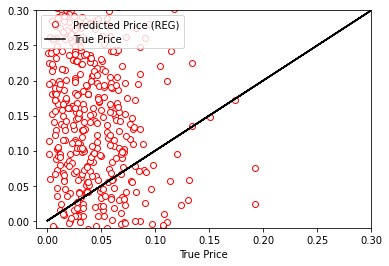

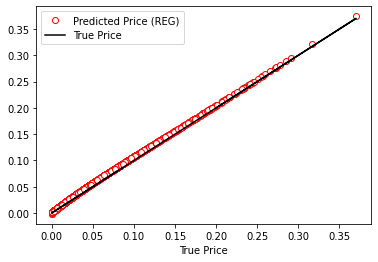

In [47]:
#Differential PCA vs. classic PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)
Zreduced = pca.transform(Z)
XtestReduced = pca.transform(xTest)

t2 = time.time()
predPricesClassic = DifferentialRegression(7, Xreduced, Y.reshape(-1,1), Zreduced, XtestReduced, 0.5)[1]
t3 = time.time()
print("train time:",t3-t2)

plt.figure()
plt.plot(truePrices, predPricesClassic, 'ro', markerfacecolor="white", label="Predicted Price (REG)")
plt.plot(truePrices, truePrices, '-', color="black", label="True Price")
plt.legend(loc = 'upper left',fontsize = 10)
plt.xlabel('True Price',fontsize = 10)
plt.xlim(-0.01,0.3)
plt.ylim(-0.01,0.3)
plt.savefig('Classic PCA.png')
plt.show()

plt.figure()
plt.plot(truePrices, predPrices, 'ro', markerfacecolor="white", label="Predicted Price (REG)")
plt.plot(truePrices, truePrices, '-', color="black", label="True Price")
plt.legend(loc = 'upper left',fontsize = 10)
plt.xlabel('True Price',fontsize = 10)
plt.show()

### Log-normal Approximation

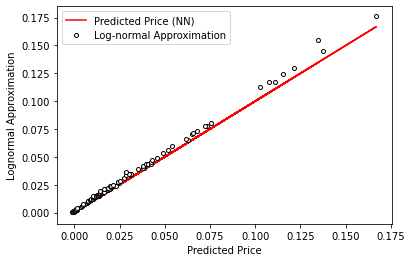

In [48]:
import pandas as pd

#Black-Scholes
def GenerateDataBlackScholesBasketNN(nSim, K, sigma, sigma0, spot, T, seed, nAssets, weights, correlation): #T is time to maturity
    vT0 = np.diag(sigma0)
    cov0 = np.linalg.multi_dot([vT0, correlation, vT0])
    chol0 = np.linalg.cholesky(cov0)
    
    vT = np.diag(sigma)
    cov = np.linalg.multi_dot([vT, correlation, vT])
    chol = np.linalg.cholesky(cov)
    
    np.random.seed(seed)
    
    T0 = 1
    
    s0 =  K * np.exp((-0.5*sigma0**2) * T0 + np.sqrt(T0)*np.dot(np.random.normal(size=(nSim,nAssets)),chol0.T)) 
    #s0 = np.random.uniform(low=0.5, high=1.5, size = (nSim, nAssets))
    b0 = np.dot(s0,weights)
    wT = np.random.normal(size=(nSim,nAssets))
    sT = s0 * np.exp((-0.5*sigma**2) * T + np.sqrt(T) * np.dot(wT,chol.T)) #sT = s0 * np.exp((-0.5*sigma**2) * T + sigma*np.sqrt(T) * np.dot(wT,chol.T))
    bT = np.dot(sT,weights)
    
    payoff = np.maximum(0, bT - K)
    deriv = np.where(bT > K, bT / b0, 0).reshape(-1, 1) * weights.reshape(1, -1)
    
    return s0.reshape(-1,nAssets), b0, payoff, deriv.reshape(-1, nAssets), cov

def BasketSigma(S,weight,cov):
    F = np.dot(S,w)
    Fi = np.mean(S,axis=0).reshape(-1,1)
    term = np.multiply(np.dot(w.reshape(-1,1),w.reshape(-1,1).T),np.exp(cov))
    finTerm = np.linalg.multi_dot([Fi.T, term, Fi])
    meanF=np.mean(F,axis=0).reshape(-1,1)
    M2 = finTerm/(meanF*meanF)
    basketSigma = np.log(M2)
    return basketSigma[0]
     
def BlackScholesBasketLogApprox(S, K, sigma, T, weights, nAssets, greek):
    F = np.dot(S,weights)
    d1 = (np.log(F/K) + 0.5 * sigma) / np.sqrt(sigma) 
    d2 = (np.log(F/K) - 0.5 * sigma) / np.sqrt(sigma)
    
    if greek == 0:
        val = F * norm.cdf(d1) - K * norm.cdf(d2)
        return val
    elif greek == 1: 
        delta = norm.cdf(d1) #delta
        return delta.reshape(-1,nAssets)
    else:
        return 0

nAssets=10
w = GenerateBasketWeights(nAssets)
corr = GenerateCorrMatrix(nAssets)
vol = vol0 = GenerateVolatilities(nAssets,0.1,0.2)
nSim=30000
nSimTest=100
T=1
K=1

X, B, Y, Z, cov = GenerateDataBlackScholesBasketNN(nSim, 1, vol, vol0, 1, T, 1996, nAssets, w, corr)

sigmaBasket = np.zeros(nSim)
for i in range(0,len(sigmaBasket)):
    F = np.dot(X[i,:],w)
    Fi = X[i,:]
    newW = np.diag(w)#np.repeat(w, 4, axis=0)#.reshape(-1,nAssets)
    firstTerm = np.dot(X[i,:],newW)
    term = np.sqrt(np.log(np.linalg.multi_dot([firstTerm,np.exp(cov),firstTerm.T])/F**2))
    sigmaBasket[i]=term
    
Xtest, Btest, Ytest, Ztest, covtest = GenerateDataBlackScholesBasketNN(nSimTest, 1, vol, vol0, 1, T, 2804, nAssets, w, corr)

sigmaBasketTest = np.zeros(nSimTest)
for i in range(0,len(sigmaBasketTest)):
    FTest = np.dot(Xtest[i,:],w)
    FiTest = Xtest[i,:]
    newWTest = np.diag(w)#np.repeat(w, 4, axis=0)#.reshape(-1,nAssets)
    firstTermTest = np.dot(Xtest[i,:],newWTest)
    termTest = np.sqrt(np.log(np.linalg.multi_dot([firstTermTest,np.exp(covtest),firstTermTest.T])/FTest**2))
    sigmaBasketTest[i]=termTest
     
normX, meanX, stdX, normY, meanY, stdY = NormalizationMultiDim(X,Y,Z)

model_MultiDim = createNeuralNetwork(4,20,nAssets)
model_MultiDim.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
history = model_MultiDim.fit(normX,[normY[:,0],normY[:,1:(nAssets+1)]], epochs = 100, batch_size = 1024, verbose = 0)

predPrices = (model_MultiDim.predict((Xtest - meanX) / stdX)[0] * stdY[0,0] + meanY[0,0])

a = Btest
c = sigmaBasketTest
d1 = (np.log(a/K) + 0.5 * c * c) / c
d2 = (np.log(a/K) - 0.5 * c * c) / c
    
truePrices = a * norm.cdf(d1) - K * norm.cdf(d2)

#print(np.column_stack((truePrices,predPrices)))
indices = np.argsort(predPrices.reshape(-1,))
testSort = np.column_stack((predPrices,truePrices))
df = pd.DataFrame(data=testSort).sort_values([1,0])
arr_sorted = df.to_numpy()

plt.figure()
plt.plot(predPrices, predPrices, 'r-', label="Predicted Price (NN)")
plt.plot(arr_sorted[:,0], arr_sorted[:,1], 'o', markerfacecolor="white", markersize=4, color="black", label="Log-normal Approximation")
plt.legend(loc = 'upper left',fontsize = 10)
plt.xlabel('Predicted Price',fontsize = 10)
plt.ylabel('Lognormal Approximation',fontsize = 10)
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.savefig('LognormalApprox.png')
plt.show()
